In [4]:
import os
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, medfilt
from scipy.interpolate import interp1d

# Butterworth Low-pass Filter
def butter_lowpass_filter(data, cutoff=20, fs=50, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


def median_filter(data, kernel_size=3):
    return medfilt(data, kernel_size=kernel_size)

# Preprocessing
def preprocess_data(df, task):
    if task in ['climbing_up', 'climbing_down']:
        middle = len(df) // 2
        df = pd.concat([df.iloc[:middle-25], df.iloc[middle+25:]])
    
    # Apply filtering
    df['ax (m/s^2)'] = butter_lowpass_filter(median_filter(df['ax (m/s^2)']))
    df['ay (m/s^2)'] = butter_lowpass_filter(median_filter(df['ay (m/s^2)']))
    df['az (m/s^2)'] = butter_lowpass_filter(median_filter(df['az (m/s^2)']))
    df['wx (rad/s)'] = butter_lowpass_filter(median_filter(df['wx (rad/s)']))
    df['wy (rad/s)'] = butter_lowpass_filter(median_filter(df['wy (rad/s)']))
    df['wz (rad/s)'] = butter_lowpass_filter(median_filter(df['wz (rad/s)']))
    
    return df

# Trimming Function
def trim_data(input_csv, output_csv, trim_start=4, trim_end=4):
    try:
        # Read the CSV file
        df = pd.read_csv(input_csv, on_bad_lines='skip')
        df['time'] = pd.to_numeric(df['time'], errors='coerce')
        
        start_time = df['time'].min() + trim_start
        end_time = df['time'].max() - trim_end
        
        trimmed_df = df[(df['time'] >= start_time) & (df['time'] <= end_time)]
        
        trimmed_df.to_csv(output_csv, index=False)
    except Exception as e:
        print(f"Error processing file {input_csv}: {e}")

# Resampling Function
def resample_to_frequency(input_csv, output_csv, new_freq=50):
    try:
        df = pd.read_csv(input_csv, on_bad_lines='skip')
        df['time'] = pd.to_numeric(df['time'], errors='coerce')
        
        if df['time'].isnull().all() or df['time'].min() == df['time'].max():
            raise ValueError("Time column has insufficient or constant data for resampling.")
        
        time_step = 1 / new_freq
        min_time, max_time = df['time'].min(), df['time'].max()
        
        if min_time == max_time:
            raise ValueError("Time range is zero; cannot define a new time range.")
        
        new_time_range = np.arange(min_time, max_time, time_step)
        
        interpolated_data = {}
        for column in df.columns:
            if column != 'time':
                interp_func = interp1d(df['time'], df[column], kind='linear', fill_value="extrapolate")
                interpolated_data[column] = interp_func(new_time_range)
        
        resampled_df = pd.DataFrame({'time': new_time_range})
        for column, values in interpolated_data.items():
            resampled_df[column] = values
        
        resampled_df = resampled_df.round(4)
        resampled_df.to_csv(output_csv, index=False)
    except Exception as e:
        print(f"Error processing file {input_csv}: {e}")

# Process Files in Folder
def process_files_in_folder(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv'):
                input_csv = os.path.join(root, file)
                output_csv = os.path.join(root, file)
                
                # Apply trimming
                trim_data(input_csv, output_csv)
                # Apply resampling
                resample_to_frequency(input_csv, output_csv)

# Main Code to Process the 'experimental_data' Folder
if __name__ == "__main__":
    # Path to the 'experimental_data' folder
    experimental_data_folder = '/Users/karthik/Documents/Task 4/Experimental_data'
    
    # Process all files in the 'experimental_data' folder
    process_files_in_folder(experimental_data_folder)



In [7]:

base_path = '/Users/karthik/Documents/Task 4/Experimental_data'

data_frames = []

def read_linear_acc_data(path, task):
    linear_acc_path = os.path.join(path, 'linear_acc.csv')

    if os.path.exists(linear_acc_path):
        print(f"Processing file: {linear_acc_path} for task: {task}")
        df = pd.read_csv(linear_acc_path)
        # Add task column
        df['task'] = task
        return df
    else:
        print(f"File not found: {linear_acc_path}")
    return pd.DataFrame()

# Loop through each folder and file
for person in os.listdir(base_path):
    person_path = os.path.join(base_path, person)
    if os.path.isdir(person_path):
        for task in os.listdir(person_path):
            task_path = os.path.join(person_path, task)
            if os.path.isdir(task_path):
                # Read data from the task folder and add task information
                df = read_linear_acc_data(task_path, task)
                if not df.empty:
                    data_frames.append(df)

# Check if any data frames were added
if data_frames:
    # Concatenate all DataFrames into a single DataFrame
    all_data = pd.concat(data_frames, ignore_index=True)

    # Sample 100 random rows
    sampled_data = all_data.sample(n=100, random_state=1)  # Set random_state for reproducibility

    # Save the sampled data to a new CSV file
    sampled_data.to_csv('sampled_linear_acc_data_with_task.csv', index=False)

    print("Sampled data with task information saved to 'sampled_linear_acc_data_with_task.csv'.")
else:
    print("No data to concatenate.")




Processing file: /Users/karthik/Documents/Task 4/Experimental_data/karthik/climbing_down/linear_acc.csv for task: climbing_down
Processing file: /Users/karthik/Documents/Task 4/Experimental_data/karthik/walking/linear_acc.csv for task: walking
Processing file: /Users/karthik/Documents/Task 4/Experimental_data/karthik/standing/linear_acc.csv for task: standing
Processing file: /Users/karthik/Documents/Task 4/Experimental_data/karthik/sitting/linear_acc.csv for task: sitting
Processing file: /Users/karthik/Documents/Task 4/Experimental_data/karthik/Climbing_up/linear_acc.csv for task: Climbing_up
Processing file: /Users/karthik/Documents/Task 4/Experimental_data/karthik/laying/linear_acc.csv for task: laying
Processing file: /Users/karthik/Documents/Task 4/Experimental_data/sambhav/climbing_down/linear_acc.csv for task: climbing_down
Processing file: /Users/karthik/Documents/Task 4/Experimental_data/sambhav/walking/linear_acc.csv for task: walking
Processing file: /Users/karthik/Document

Cross-validation scores: [0.67233126 0.66108186 0.67201341 0.65549437 0.67129519]
Mean accuracy: 0.6664432169922756
Standard deviation: 0.006897231553449819
Classification Report:
               precision    recall  f1-score   support

  Climbing_up       0.75      0.75      0.75      1219
climbing_down       0.79      0.77      0.78      1397
       laying       0.56      0.56      0.56       448
      sitting       0.52      0.46      0.49       423
     standing       0.56      0.64      0.60       343
      walking       0.47      0.49      0.48       348

     accuracy                           0.68      4178
    macro avg       0.61      0.61      0.61      4178
 weighted avg       0.68      0.68      0.68      4178



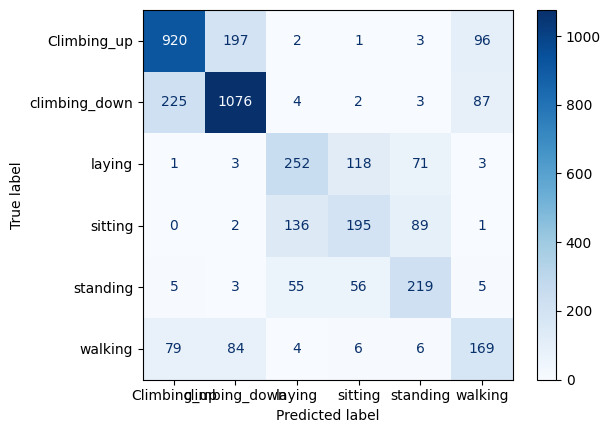

In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def load_data(base_folder):
    data = []
    labels = []
    
    for person in os.listdir(base_folder):
        person_folder = os.path.join(base_folder, person)
        if not os.path.isdir(person_folder):
            continue
        for activity in os.listdir(person_folder):
            activity_folder = os.path.join(person_folder, activity)
            if not os.path.isdir(activity_folder):
                continue
            linear_acc_path = os.path.join(activity_folder, 'linear_acc.csv')
            if os.path.exists(linear_acc_path):
                df = pd.read_csv(linear_acc_path)
                
                df['label'] = activity
                data.append(df)
                labels.append(activity)
    
    
    df_combined = pd.concat(data, ignore_index=True)
    return df_combined


base_folder = '/Users/karthik/Documents/Task 4/Experimental_data'  # Update with your base folder path
df = load_data(base_folder)


X = df.drop('label', axis=1)
y = df['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


clf = DecisionTreeClassifier()

k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# cross-validation
scores = cross_val_score(clf, X, y_encoded, cv=kf)

print(f'Cross-validation scores: {scores}')
print(f'Mean accuracy: {scores.mean()}')
print(f'Standard deviation: {scores.std()}')

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree classifier
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(label_encoder.classes_)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', include_values=True, values_format='d')
plt.show()